<font color='red'>__Important note:__ This notebook has been modified from its original version. Some cells have been removed, added, or modified and file paths and URLs have been updated.</font>

For original version, go to https://github.com/berenslab/mini-atlas/blob/master/code/allen-data-preprocess.ipynb

# Process Allen data

This notebook requires downloading raw Allen Institute data.<br>
*note: this cell has been updated to accomodate URL changes, remove information on files already provided,and supplement repo information*

**Yao et al. 2020 data**

  *  Get `umi_counts.h5` files from the following folders and put them into folders with the same names in our `data/raw/allen/yao2020/`:
    * https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v2/mouse/processed/analysis/10X_cells_v2_AIBS/
    * https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/
    * https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/sncell/10x_v2/mouse/processed/analysis/10X_nuclei_v2_AIBS/
    * https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/sncell/10x_v3/mouse/processed/analysis/10X_nuclei_v3_AIBS/
    * https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/sncell/10x_v3/mouse/processed/analysis/10X_nuclei_v3_Broad/
  * Get `exon.counts.csv.gz` and `intron.counts.csv.gz` files from the following folders and put them into respective folders (`SmartSeq_cells_AIBS` and `SmartSeq_nuclei_AIBS`) in our `data/raw/allen/yao2020/`:
    * https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/SSv4/mouse/processed/analysis/SMARTer_cells_MOp/
    * https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/sncell/SSv4/mouse/processed/analysis/SMARTer_nuclei_MOp/
    
**Tasic et al. 2018 data**

Download the data from here: http://celltypes.brain-map.org/rnaseq and unpack into `data/raw/allen/tasic2018/`. Direct links:

  * VISp: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413985
  * ALM: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413179

Information about cluster colors and labels is contained in the `sample_heatmap_plot_data.csv` contained in this repository. It can also be obtrained through the interactive data browser http://celltypes.brain-map.org/rnaseq/mouse/v1-alm: go to "Sample Heatmaps", click "Build Plot!" and then "Download data as CSV".

**FIt-SNE repository**

You will need to clone the FIt-SNE Github repository to run this notebook. The URL is https://github.com/KlugerLab/FIt-SNE. Clone it at the same directory level as this repo, or as specified in the next code cell, ../../Flt-SNE.

After cloning, follow the instructions on README to compile everything. Note that you need gfortran and FFTW installed to get the repo set up. If you find the README somewhat unclear, this Kaggle page may help you get started: https://www.kaggle.com/returnofsputnik/mnist-2d-t-sne-with-fit-sne-cpu-only.

In [2]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from scipy import sparse

sns.set_style('ticks')

import sys
sys.path.append('../../FIt-SNE')
from fast_tsne import fast_tsne

import rnaseqTools

## Allen datasets overview

In [3]:
# Sanity checking

clusterMemb = pd.read_csv('../data/raw/allen/yao2020/cluster.membership.csv')

print(np.min(clusterMemb['x'].values))
print(np.max(clusterMemb['x'].values))
print(np.unique(clusterMemb['x'].values).size)
print(np.sum(np.isnan(clusterMemb['x'].values)))

clusterAnn = pd.read_csv('../data/raw/allen/yao2020/cluster.annotation.csv')
clusterAnn = clusterAnn.sort_values('cluster_id')
clusterAnn

1
116
116
0


,cluster_id,cluster_label,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,cl,cluster_size,tree_order
0,1,Lamp5 Pax6,#DDACC9,1,Lamp5,#DA808C,1,GABAergic,#F05A28,1,700,1
1,2,Lamp5 Egln3_1,#FF88AD,1,Lamp5,#DA808C,1,GABAergic,#F05A28,2,618,2
2,3,Lamp5 Egln3_2,#DD8091,1,Lamp5,#DA808C,1,GABAergic,#F05A28,3,814,3
3,4,Lamp5 Egln3_3,#F08E98,1,Lamp5,#DA808C,1,GABAergic,#F05A28,4,1276,4
4,5,Lamp5 Pdlim5_1,#FF7290,1,Lamp5,#DA808C,1,GABAergic,#F05A28,5,1288,5
...,...,...,...,...,...,...,...,...,...,...,...,...
111,112,Peri,#A77C70,21,Peri,#665547,3,Other,#808080,103,1532,112
112,113,Micro,#6E7C6F,22,Micro-PVM,#94AF97,3,Other,#808080,106,8110,113
113,114,PVM_1,#8BA38D,22,Micro-PVM,#94AF97,3,Other,#808080,108,323,114
114,115,PVM_2,#73967F,22,Micro-PVM,#94AF97,3,Other,#808080,107,30,115


In [4]:
datasets = np.array([c.split('.')[0] for c in clusterMemb.values[:,0]])
datasetsUnique = np.unique(datasets)
clusterNames = clusterAnn['cluster_label'].values

neural_clusters = np.arange(np.where(clusterNames=='Astro_Top2a')[0][0])+1
meis_clusters = np.arange(np.where(clusterNames=='Meis2')[0][0],
                          np.where(clusterNames=='Astro_Top2a')[0][0])+1

for d in datasetsUnique:
    clusters = clusterMemb.values[:,1][datasets==d]    
    neurons = np.isin(clusters, neural_clusters)
    meis    = np.isin(clusters, meis_clusters)
    covered = np.unique(clusters)    
    print('{:20} {:6}   {:6}   {:6}   {:3}   {:3}   {:3}   {:3}'.format(d, 
            clusters.size, np.sum(neurons), np.sum(~neurons), np.sum(meis),
            np.sum(np.isin(covered, neural_clusters)), 
            np.sum(~np.isin(covered, neural_clusters)),
            np.sum(np.isin(covered, meis_clusters))))

10X_cells_v2_AIBS    122641   121423     1218     0    87    21     0
10X_cells_v3_AIBS     71183    69722     1461     0    85    17     0
10X_nuclei_v2_AIBS    76525    75672      853     0    86    16     0
10X_nuclei_v3_AIBS    40166    39706      460     1    86    21     1
10X_nuclei_v3_Broad  159738   101640    58098    96    90    26     2
SmartSeq_cells_AIBS    6288     6245       43     0    83     9     0
SmartSeq_nuclei_AIBS   6171     5914      257     0    84    13     0


In [5]:
import tables

def load_allen_genes(folder):
    if 'SmartSeq' in folder:
        data = pd.read_csv('../data/raw/allen/yao2020/' + folder + '/exon.counts.csv.gz', engine='c', 
                           na_filter=False, usecols=[0,1])
        genes = data.values[:,0]
    else:
        f = tables.open_file('../data/raw/allen/yao2020/' + folder + '/umi_counts.h5', 'r')
        group = f.get_node(f.root, 'matrix/features')
        genes = getattr(group, 'name').read().astype(str)
    return genes

for folder in ['10X_cells_v2_AIBS', '10X_nuclei_v2_AIBS',
               '10X_cells_v3_AIBS', '10X_nuclei_v3_AIBS', '10X_nuclei_v3_Broad',
               'SmartSeq_cells_AIBS', 'SmartSeq_nuclei_AIBS']:
               
    g = load_allen_genes(folder) 
    print('{:20} {}'.format(folder, g.size))

10X_cells_v2_AIBS    31053
10X_nuclei_v2_AIBS   31053
10X_cells_v3_AIBS    31053
10X_nuclei_v3_AIBS   31053
10X_nuclei_v3_Broad  31053
SmartSeq_cells_AIBS  45768
SmartSeq_nuclei_AIBS 45768


In [6]:
cl, clcount = np.unique(clusterMemb['x'], return_counts=True)
print('{:20}  {}\n'.format('TOTAL', clusterMemb.shape[0]))
for cl, clcount in zip(clusterAnn['cluster_label'], clcount):
    print('{:20}  {}'.format(cl,clcount))

TOTAL                 482712

Lamp5 Pax6            700
Lamp5 Egln3_1         618
Lamp5 Egln3_2         814
Lamp5 Egln3_3         1276
Lamp5 Pdlim5_1        1288
Lamp5 Pdlim5_2        2221
Lamp5 Slc35d3         6850
Lamp5 Lhx6            633
Sncg Col14a1          697
Sncg Slc17a8          498
Sncg Calb1_1          321
Sncg Calb1_2          175
Sncg Npy2r            863
Vip Sncg              546
Vip Serpinf1_1        254
Vip Serpinf1_2        855
Vip Serpinf1_3        315
Vip Htr1f             1940
Vip Gpc3              1518
Vip C1ql1             1838
Vip Mybpc1_1          803
Vip Mybpc1_2          2361
Vip Mybpc1_3          1064
Vip Chat_1            3350
Vip Chat_2            1060
Vip Igfbp6_1          963
Vip Igfbp6_2          816
Sst Chodl             876
Sst Penk              497
Sst Myh8_1            3161
Sst Myh8_2            889
Sst Myh8_3            419
Sst Htr1a             697
Sst Etv1              290
Sst Pvalb Etv1        342
Sst Crhr2_1           1657
Sst Crhr2_2          

## Do feature selection and compress Allen datasets

In [7]:
import tables

def load_allen_data(folder):
    if 'SmartSeq' in folder:
        # in chunks to prevent Pandas from eating a huge amount of RAM
        genes = []
        sparseblocks = []
        for i,chunk in enumerate(pd.read_csv('../data/raw/allen/yao2020/' + folder + '/exon.counts.csv.gz',
                                             chunksize=1000, na_filter=False, index_col=0)):
            if i==0:
                cells = np.array(chunk.columns)
            genes.extend(list(chunk.index))
            sparseblock = scipy.sparse.csr_matrix(chunk.values.astype(float))
            sparseblocks.append([sparseblock])
        counts = scipy.sparse.bmat(sparseblocks).transpose()   
        genes = np.array(genes)
        
        # now load the intron table
        genes_introns = []
        sparseblocks = []
        for i,chunk in enumerate(pd.read_csv('../data/raw/allen/yao2020/' + folder + '/intron.counts.csv.gz',
                                             chunksize=1000, na_filter=False, index_col=0)):
            if i==0:
                cells_introns = np.array(chunk.columns)
            genes_introns.extend(list(chunk.index))
            sparseblock = scipy.sparse.csr_matrix(chunk.values.astype(float))
            sparseblocks.append([sparseblock])
        counts_introns = scipy.sparse.bmat(sparseblocks).transpose()   
        assert(all(cells==cells_introns))
        assert(all(genes==genes_introns))

    else:
        f = tables.open_file('../data/raw/allen/yao2020/' + folder + '/umi_counts.h5', 'r')
        group = f.get_node(f.root, 'matrix/features')
        genes = getattr(group, 'name').read().astype(str)
        group = f.get_node(f.root, 'matrix')
        cells = getattr(group, 'barcodes').read().astype(str)
        data = getattr(group, 'data').read()
        indices = getattr(group, 'indices').read()
        indptr = getattr(group, 'indptr').read()
        shape = getattr(group, 'shape').read()
        counts = scipy.sparse.csc_matrix((data, indices, indptr), shape=shape)
        counts = counts.transpose()
            
    clusterMemb = pd.read_csv('../data/raw/allen/yao2020/cluster.membership.csv')
    if 'SmartSeq' in folder:
        name2id = [(c[0].split('.')[1], c[1]) for c in clusterMemb.values 
                   if c[0].split('.')[0]==folder]
    else:
        name2id = [(c[0].split('.')[1].split('L')[0], c[1]) for c in clusterMemb.values 
                   if c[0].split('.')[0]==folder]
    name2id = dict(name2id)

    ind = np.isin(cells, list(name2id))
    counts = counts[ind,:]
    cells = cells[ind]
    clusters = np.array([name2id[c] for c in cells]).astype(int) - 1
        
    clusterAnn = pd.read_csv('../data/raw/allen/yao2020/cluster.annotation.csv')
    clusterColors = np.array(clusterAnn['cluster_color'])
    clusterNames  = np.array(clusterAnn['cluster_label'])
            
    m1data = {'counts': counts, 'genes': genes, 'cells': cells,
              'clusters': clusters, 'clusterColors': clusterColors, 'clusterNames': clusterNames}
    
    if 'SmartSeq' in folder:
        m1data['intronCounts'] = counts_introns
        
    return m1data

In [8]:
def reduce(m1data, subset_clusters, geneNumber, threshold, clusters_to_keep):
    seqDepths = np.array(m1data['counts'].sum(axis=1))
    subset_cells = np.isin(m1data['clusters'], subset_clusters)
    subset_impGenes = rnaseqTools.geneSelection(
        m1data['counts'][subset_cells,:], n=geneNumber, decay=1.5, plot=False, threshold=threshold)
    data_reduced = {'counts': m1data['counts'][:,subset_impGenes][subset_cells,:],
                    'genes' : m1data['genes'][subset_impGenes],
                    'clusters': m1data['clusters'][subset_cells],
                    'clusterColors': m1data['clusterColors'][clusters_to_keep], 
                    'clusterNames': m1data['clusterNames'][clusters_to_keep],
                    'seqDepths': seqDepths[subset_cells]}
    
    if 'intronCounts' in m1data:
        intronSeqDepths = np.array(m1data['intronCounts'].sum(axis=1))
        data_reduced['intronCounts'] = m1data['intronCounts'][:,subset_impGenes][subset_cells,:]
        data_reduced['intronSeqDepths'] = intronSeqDepths
    return data_reduced
    
    
def compress(m1data, threshold):
    m1data_compressed = {}
    
    neural_clusters = np.arange(np.where(m1data['clusterNames']=='Meis2')[0][0])
    m1data_compressed['neurons'] = reduce(m1data, neural_clusters, 1000, threshold, neural_clusters)

    subset_clusters = [i for i,c in enumerate(m1data['clusterNames']) if c[:3]=='Sst' or c[:5]=='Pvalb']
    m1data_compressed['pvsst'] = reduce(m1data, subset_clusters, 500, threshold, neural_clusters)

    subset_clusters = [i for i,c in enumerate(m1data['clusterNames']) if c[:3]=='Vip' 
                       or c[:5]=='Lamp5' or c[:4]=='Sncg']
    m1data_compressed['viplamp'] = reduce(m1data, subset_clusters, 500, threshold, neural_clusters)

    subset_clusters = [i for i,c in enumerate(m1data['clusterNames']) if c[0]=='L' and c[1]!='a']
    m1data_compressed['exc'] = reduce(m1data, subset_clusters, 500, threshold, neural_clusters)
    
    return m1data_compressed

In [9]:
 %%time

# Loop over datasets    
for folder in ['10X_cells_v2_AIBS', '10X_nuclei_v2_AIBS',
               '10X_cells_v3_AIBS', '10X_nuclei_v3_AIBS',
               'SmartSeq_cells_AIBS', 'SmartSeq_nuclei_AIBS',
               '10X_nuclei_v3_Broad']:
                
    print('Processing ' + folder + '... ')

    m1data = load_allen_data(folder)       
    if 'SmartSeq' in folder:
        threshold = 32
    else:
        threshold = 0
    m1data_compressed = compress(m1data, threshold)
    
    pickle.dump(m1data_compressed, open('../data/processed/reduced-allen-data/' + folder + '.pickle', 'wb'), protocol=4)
    m1data = []

Processing 10X_cells_v2_AIBS... 
Chosen offset: 0.32
Chosen offset: 0.39
Chosen offset: 0.38
Chosen offset: 0.39
Processing 10X_nuclei_v2_AIBS... 
Chosen offset: 0.09
Chosen offset: 0.12
Chosen offset: 0.12
Chosen offset: 0.13
Processing 10X_cells_v3_AIBS... 
Chosen offset: 0.71
Chosen offset: 0.88
Chosen offset: 0.92
Chosen offset: 0.83
Processing 10X_nuclei_v3_AIBS... 
Chosen offset: 0.78
Chosen offset: 0.84
Chosen offset: 0.86
Chosen offset: 0.83
Processing SmartSeq_cells_AIBS... 
Chosen offset: 6.42
Chosen offset: 6.30
Chosen offset: 6.66
Chosen offset: 6.39
Processing SmartSeq_nuclei_AIBS... 
Chosen offset: 7.17
Chosen offset: 7.32
Chosen offset: 7.70
Chosen offset: 7.16
Processing 10X_nuclei_v3_Broad... 
Chosen offset: 0.32
Chosen offset: 0.41
Chosen offset: 0.44
Chosen offset: 0.42
CPU times: user 15min 59s, sys: 31min 11s, total: 47min 11s
Wall time: 1h 8min 8s


## (Optional) Quickly update cluster annotations if needed
No need to run this unless annotation changed.

In [2]:
clusterAnn = pd.read_csv('../data/raw/allen/yao2020/cluster.annotation.csv')
clusterAnn = clusterAnn.sort_values('cluster_id')
clusterColors = np.array(clusterAnn['cluster_color'])
clusterNames  = np.array(clusterAnn['cluster_label'])
neural_clusters = np.arange(np.where(clusterNames=='Meis2')[0][0])

for folder in ['10X_cells_v2_AIBS', '10X_nuclei_v2_AIBS',
               '10X_cells_v3_AIBS', '10X_nuclei_v3_AIBS',
               'SmartSeq_cells_AIBS', 'SmartSeq_nuclei_AIBS',
               '10X_nuclei_v3_Broad']:
                
    print('Processing ' + folder + '... ')

    with open('../data/processed/reduced-allen-data/' + folder + '.pickle', 'rb') as f:
        m1data = pickle.load(f)
        for subset in m1data:
            m1data[subset]['clusterNames'] = clusterNames[neural_clusters]
            m1data[subset]['clusterColors'] = clusterColors[neural_clusters]
    
    with open('../data/processed/reduced-allen-data/' + folder + '.pickle', 'wb') as f:
        pickle.dump(m1data, f, protocol=4)    

Processing 10X_cells_v2_AIBS... 
Processing 10X_nuclei_v2_AIBS... 
Processing 10X_cells_v3_AIBS... 
Processing 10X_nuclei_v3_AIBS... 
Processing SmartSeq_cells_AIBS... 
Processing SmartSeq_nuclei_AIBS... 
Processing 10X_nuclei_v3_Broad... 


## Allen t-SNEs

In [10]:
# This uses Euclidean distance in the PCA space. Only points that were not in the downsampled subset
# are positioned on the downsampled tSNE.

def map_to_downsampled_tsne(X, Z, downsampled_ind, batchsize=1000, knn=10):
    ind_rest = np.where(~np.isin(np.arange(X.shape[0]), downsampled_ind))[0]
    steps = int(np.ceil(ind_rest.size/batchsize))
    assignmentPositions = np.zeros((X.shape[0], 2))
    assignmentPositions[downsampled_ind,:] = Z
    
    def pdist2(A,B):
        return np.sum(A**2,axis=1)[:, None] + np.sum(B**2, axis=1)[None, :] - 2 * A @ B.T

    for i in range(steps):
        print('.', end='', flush=True)
        endind = np.min(((i+1)*batchsize, ind_rest.size))
        batch = ind_rest[i*batchsize:endind]
        D = pdist2(X[batch, :], X[downsampled_ind,:])
        ind = np.argpartition(D, knn)[:, :knn]
        for i in range(batch.size):
            assignmentPositions[batch[i],:] = np.median(Z[ind[i,:],:], axis=0)
    print('', flush=True)
    
    return assignmentPositions


# Pipeline for using downsampling-based initialisation
def downsampling_based_tsne(X, subsetSize=25000, seed=42, exaggeration=1):
    np.random.seed(seed)
    indSubset = np.random.choice(X.shape[0], subsetSize, replace=False)
    
    # Note that this assumes that X was already PCA-transformed
    pcaInit = X[:,:2] / np.std(X[:,0]) * 0.0001
    
    Zsubset = fast_tsne(X[indSubset,:], perplexity_list=[30, int(subsetSize/100)], 
                        initialization = pcaInit[indSubset,:],
                        learning_rate = subsetSize/12)

    pos = map_to_downsampled_tsne(X, Zsubset, indSubset)
    downsampled_init = pos / np.std(pos[:,0]) * 0.0001

    Z = fast_tsne(X, perplexity=30, initialization=downsampled_init, 
                  learning_rate=X.shape[0]/12, late_exag_coeff=exaggeration, 
                  start_late_exag_iter=250)
    
    return Z

In [11]:
%%time

m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))['neurons']

impGenes = rnaseqTools.geneSelection(m1data['counts'], n=1000, decay=1.5, plot=False)
X = np.log2(m1data['counts'][:, impGenes] / m1data['seqDepths'] * np.median(m1data['seqDepths']) + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

Z = downsampling_based_tsne(X)
pickle.dump(Z, open('../data/processed/rnaseq/10x-tsne-big.pickle', 'wb'))

Chosen offset: 0.31
.................................................................................................
CPU times: user 2min 34s, sys: 34.4 s, total: 3min 9s
Wall time: 7min 25s


<IPython.core.display.Javascript object>


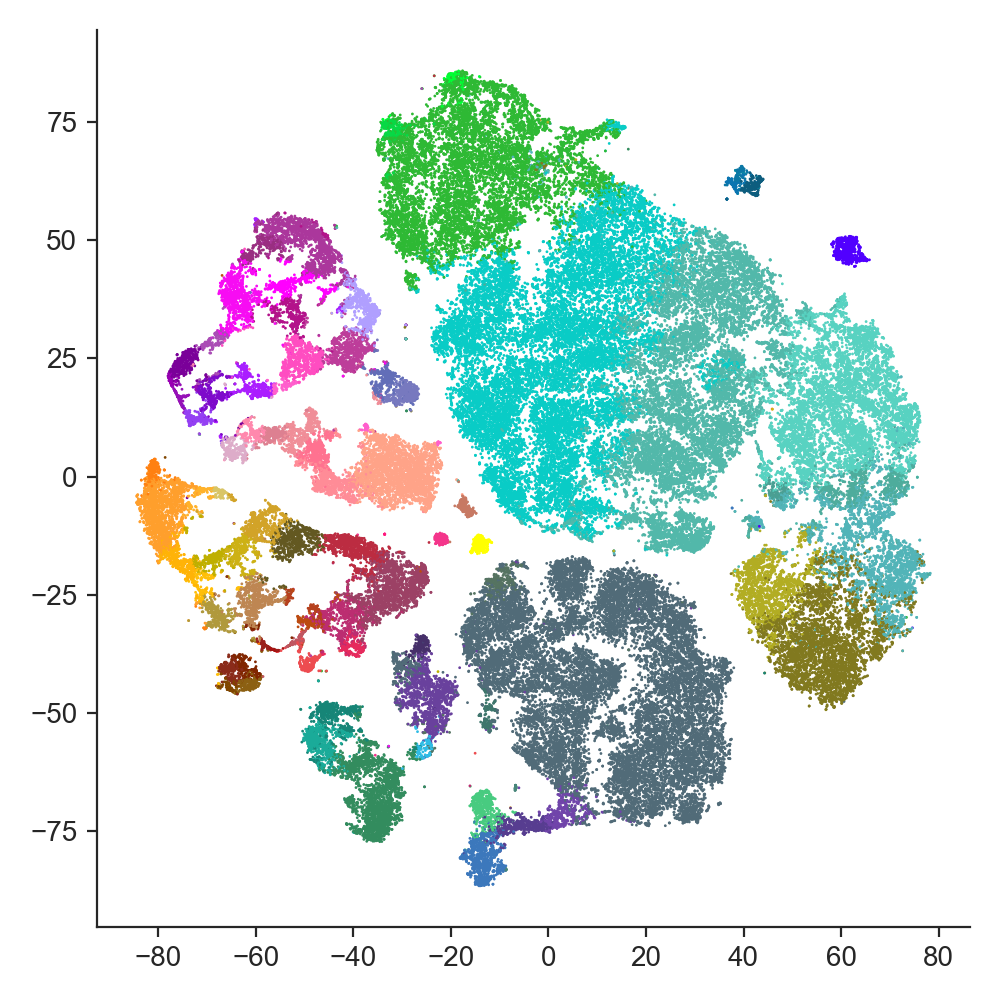

In [12]:
plt.figure(figsize=(5,5))
col = m1data['clusterColors'][m1data['clusters']]
plt.scatter(Z[:,0],Z[:,1],s=1,c=col,edgecolors='none')
sns.despine()
plt.tight_layout()

In [13]:
%%time

m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))

def subset_tsne(key, perplexity=30):
#     X = np.log2(m1data[key]['counts'] / m1data[key]['seqDepths'] * 1e+6 + 1)  
    X = np.log2(m1data[key]['counts'] / m1data[key]['seqDepths'] * np.median(m1data[key]['seqDepths']) + 1)  
    X = np.array(X)
    X = X - X.mean(axis=0)
    U,s,V = np.linalg.svd(X, full_matrices=False)
    U[:, np.sum(V,axis=1)<0] *= -1
    X = np.dot(U, np.diag(s))
    X = X[:, np.argsort(s)[::-1]][:,:50]
    
    PCAinit = X[:,:2]/np.std(X[:,0])*.0001
    Z = fast_tsne(X, perplexity=perplexity, initialization=PCAinit, learning_rate=X.shape[0]/12)

    return Z
    
Z1 = subset_tsne('pvsst')
Z2 = subset_tsne('viplamp')
Z3 = subset_tsne('exc', perplexity=100)

pickle.dump(Z1, open('../data/processed/rnaseq/10x-tsne-pvsst.pickle', 'wb'))
pickle.dump(Z2, open('../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'wb'))
pickle.dump(Z3, open('../data/processed/rnaseq/10x-tsne-exc.pickle', 'wb'))

CPU times: user 31.9 s, sys: 5.91 s, total: 37.8 s
Wall time: 10min 47s


<IPython.core.display.Javascript object>


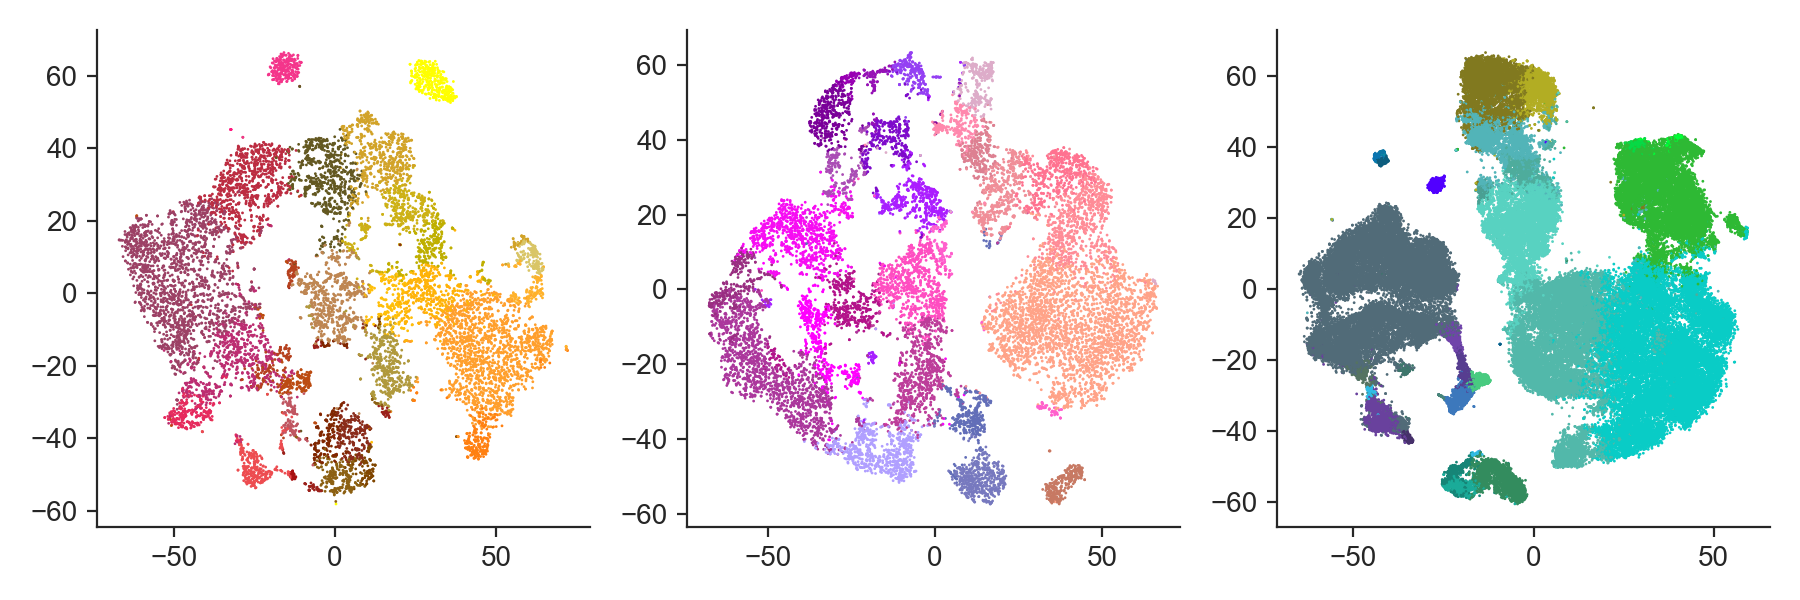

In [14]:
plt.figure(figsize=(9,3))
plt.subplot(131)
col = m1data['pvsst']['clusterColors'][m1data['pvsst']['clusters']]
plt.scatter(Z1[:,0],Z1[:,1],s=1,c=col,edgecolors='none')
plt.subplot(132)
col = m1data['viplamp']['clusterColors'][m1data['viplamp']['clusters']]
plt.scatter(Z2[:,0],Z2[:,1],s=1,c=col,edgecolors='none')
plt.subplot(133)
col = m1data['exc']['clusterColors'][m1data['exc']['clusters']]
plt.scatter(Z3[:,0],Z3[:,1],s=1,c=col,edgecolors='none')
sns.despine()
plt.tight_layout()

In [15]:
%%time

tsnes = {}

for folder in ['10X_cells_v2_AIBS', '10X_nuclei_v2_AIBS',
               '10X_cells_v3_AIBS', '10X_nuclei_v3_AIBS',
               'SmartSeq_cells_AIBS', 'SmartSeq_nuclei_AIBS',
               '10X_nuclei_v3_Broad']:

    print('Processing ' + folder + '... ')

    m1data = pickle.load(open('../data/processed/reduced-allen-data/' + folder + '.pickle', 'rb'))['neurons']

    if 'SmartSeq' in folder:
        threshold=32
        denom = 1e+6
    else:
        threshold=0
        denom = np.median(m1data['seqDepths'])
    
    X = np.log2(m1data['counts'] / m1data['seqDepths'] * denom + 1)  
    X = np.array(X)
    X = X - X.mean(axis=0)
    U,s,V = np.linalg.svd(X, full_matrices=False)
    U[:, np.sum(V,axis=1)<0] *= -1
    X = np.dot(U, np.diag(s))
    X = X[:, np.argsort(s)[::-1]][:,:50]

    if 'SmartSeq' in folder:
        Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], 
                      initialization = X[:,:2] / np.std(X[:,0]) * 0.0001, 
                      learning_rate = X.shape[0]/12)    
    else:
        Z = downsampling_based_tsne(X)
        
    tsnes[folder] = Z
    pickle.dump(tsnes, open('../data/processed/rnaseq/references-tsnes.pickle', 'wb'))

Processing 10X_cells_v2_AIBS... 
.................................................................................................
Processing 10X_nuclei_v2_AIBS... 
...................................................
Processing 10X_cells_v3_AIBS... 
.............................................
Processing 10X_nuclei_v3_AIBS... 
...............
Processing SmartSeq_cells_AIBS... 
Processing SmartSeq_nuclei_AIBS... 
Processing 10X_nuclei_v3_Broad... 
.............................................................................
CPU times: user 8min 27s, sys: 1min 57s, total: 10min 24s
Wall time: 37min 44s


<IPython.core.display.Javascript object>


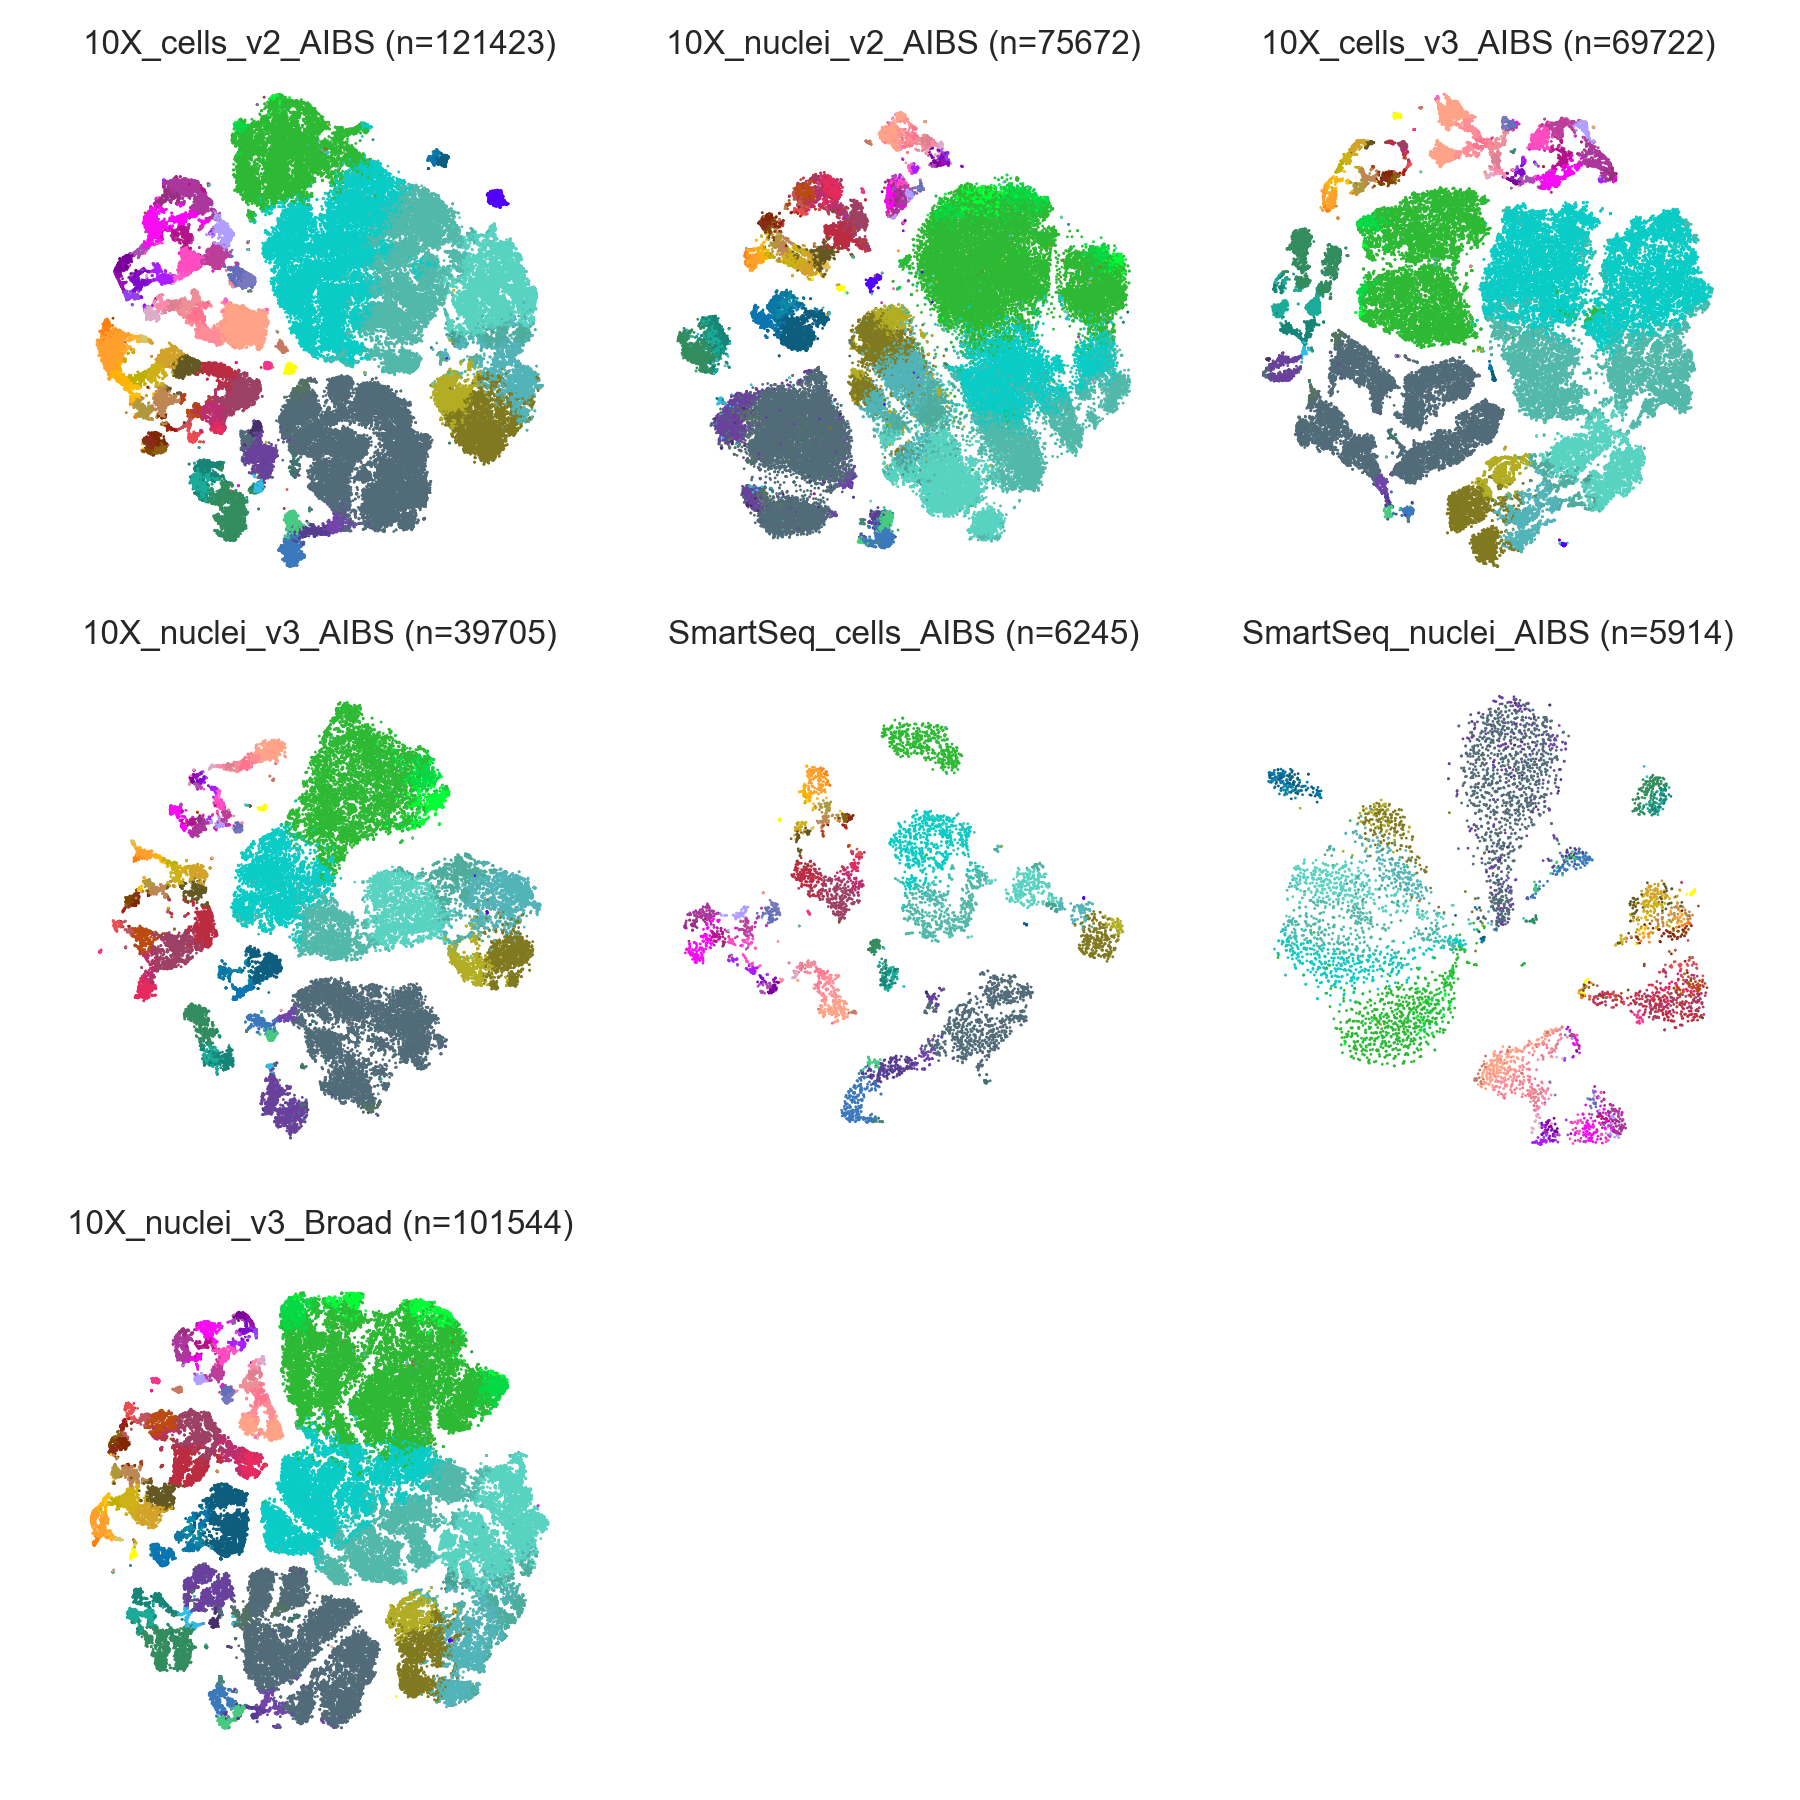

In [16]:
tsnes = pickle.load(open('../data/processed/rnaseq/references-tsnes.pickle', 'rb'))
plt.figure(figsize=(9,9))

for subpl,folder in enumerate(
    ['10X_cells_v2_AIBS', '10X_nuclei_v2_AIBS',
     '10X_cells_v3_AIBS', '10X_nuclei_v3_AIBS',
     'SmartSeq_cells_AIBS', 'SmartSeq_nuclei_AIBS',
     '10X_nuclei_v3_Broad'], 1):

    m1data = pickle.load(open('../data/processed/reduced-allen-data/' + folder + '.pickle', 'rb'))['neurons']
    col = m1data['clusterColors'][m1data['clusters']]
    Z = tsnes[folder]
    
    plt.subplot(3,3,subpl)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(Z[:,0], Z[:,1], s=1, c=col, edgecolor='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(folder + ' (n={})'.format(Z.shape[0]))
    
sns.despine(left=True, bottom=True)
plt.tight_layout()

## Compress Tasic et al. 2018 dataset

In [17]:
%%time

# THIS CELL IS COPY-PASTED FROM THE ART OF TSNE DEMO NOTEBOOK
# file paths may need to be modified depending on dataset version

def sparseload(filenames):
    genes = []
    sparseblocks = []
    areas = []
    cells = []
    for chunk1,chunk2 in zip(pd.read_csv(filenames[0], chunksize=1000, index_col=0, na_filter=False),
                             pd.read_csv(filenames[1], chunksize=1000, index_col=0, na_filter=False)):
        if len(cells)==0:
            cells = np.concatenate((chunk1.columns, chunk2.columns))
            areas = [0]*chunk1.columns.size + [1]*chunk2.columns.size
        
        assert(np.all(chunk1.index==chunk2.index))
        genes.extend(list(chunk1.index))
        sparseblock1 = sparse.csr_matrix(chunk1.values.astype(float))
        sparseblock2 = sparse.csr_matrix(chunk2.values.astype(float))
        sparseblock = sparse.hstack((sparseblock1,sparseblock2), format='csr')
        sparseblocks.append([sparseblock])
        print('.', end='', flush=True)
    print(' done')
    counts = sparse.bmat(sparseblocks)
    return (counts.T, np.array(genes), cells, np.array(areas))

filenames = ['../data/raw/allen/tasic2018/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_exon-matrix.csv',
             '../data/raw/allen/tasic2018/mouse_ALM_gene_expression_matrices_2018-06-14/mouse_ALM_2018-06-14_exon-matrix.csv']
counts, genes, cells, areas = sparseload(filenames)

genesDF = pd.read_csv('../data/raw/allen/tasic2018/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('../data/raw/allen/tasic2018/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

.............................................. done
CPU times: user 4min 51s, sys: 32.1 s, total: 5min 23s
Wall time: 5min 31s


In [18]:
impGenes = rnaseqTools.geneSelection(counts, threshold=32, n=3000, decay=1.5, plot=False)
seqDepths = np.array(counts.sum(axis=1))

Chosen offset: 6.56


In [19]:
%%time

# Load intron counts as well

filenames = ['../data/raw/allen/tasic2018/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_intron-matrix.csv',
             '../data/raw/allen/tasic2018/mouse_ALM_gene_expression_matrices_2018-06-14/mouse_ALM_2018-06-14_intron-matrix.csv']
counts_intron, genes_intron, cells_intron, areas_intron = sparseload(filenames)
genes_intron = np.array([id2symbol[g] for g in genes_intron])

assert(all(genes==genes_intron))
assert(all(cells==cells_intron))
assert(all(areas==areas_intron))

counts_intron = counts_intron[ind, :]

intronSeqDepths = np.array(counts_intron.sum(axis=1))

.............................................. done
CPU times: user 4min 23s, sys: 24 s, total: 4min 47s
Wall time: 35min 47s


In [20]:
tasic2018reduced = {'counts': counts[:,impGenes],
                    'genes' : genes[impGenes],
                    'areas': areas, 
                    'clusters': clusters,
                    'clusterColors': clusterColors,
                    'clusterNames': clusterNames,
                    'seqDepths': seqDepths,
                    'intronCounts': counts_intron[:,impGenes],
                    'intronSeqDepths': intronSeqDepths}

pickle.dump(tasic2018reduced, open('../data/processed/reduced-allen-data/tasic2018.pickle', 'wb'))